In [1]:
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import torch
import torch.distributions as D
import torch.functional as F
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data

from IPython.display import display, clear_output, HTML
from matplotlib.animation import FuncAnimation
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
seed = 0
np.random.seed(seed)
_ = torch.manual_seed(seed)
plt.style.use("fivethirtyeight")

In [3]:
num_categories = 3
num_data_points_per_category = 200
batch_size = 128
time_steps = 250
beta = 0.015
learning_rate = 1e-2
weight_decay = 1e-6
epochs = 50
log_steps = 25

In [4]:
def generate_training_samples(num_data_points_per_category: int):
    category_means = torch.tensor([-5.0, 0.0, 5.0]).unsqueeze(dim=1)
    category_stddevs = torch.tensor([1.0, 1.0, 1.5]).unsqueeze(dim=1)
    data_samples = []
    data_labels = []
    color_map = plt.get_cmap("tab10", num_categories)

    for category in range(num_categories):
        category_distribution = D.MultivariateNormal(
            category_means[category], torch.diag(category_stddevs[category])
        )
        category_samples = category_distribution.sample([num_data_points_per_category])
        data_samples.append(category_samples)
        category_labels = torch.full((num_data_points_per_category,), category)
        data_labels.append(category_labels)

    synthetic_data = torch.cat(data_samples, dim=0)
    synthetic_labels = torch.cat(data_labels, dim=0)

    dataset = Data.TensorDataset(synthetic_data, synthetic_labels)
    shuffle_indices = torch.randperm(num_categories * num_data_points_per_category)
    shuffled_dataset = dataset[shuffle_indices]
    color_dict = {i: color_map(i) for i in range(num_categories)}

    return shuffled_dataset, color_dict

In [5]:
dataset, color_map = generate_training_samples(num_data_points_per_category)
x_train, y_train = dataset
y_train = y_train.numpy()
train_loader = Data.DataLoader(x_train, batch_size=batch_size, shuffle=True)

In [6]:
def forward_diffusion(data: torch.Tensor, time_steps: int, beta: float):
    x_t = data
    distributions, samples = [None], [x_t]
    sqrt_beta = np.sqrt(beta)
    sqrt_one_minus_beta = np.sqrt(1 - beta)

    for _ in range(time_steps):
        q = D.Normal(sqrt_one_minus_beta * x_t, sqrt_beta)
        x_t = q.sample()
        distributions.append(q)
        samples.append(x_t)

    return distributions, torch.stack(samples)


def reverse_diffusion(mu_model, sigma_model, num_samples: int, time_steps: int):
    data_shape = (
        num_samples,
        1,
    )
    p = D.Normal(torch.zeros(data_shape), torch.ones(data_shape))
    x_t = p.sample()
    sample_history = [x_t]

    for t in range(time_steps, 0, -1):
        inputs = torch.cat([x_t, torch.ones(data_shape) * t / time_steps], dim=1)
        mu = mu_model(inputs)
        sigma = sigma_model(inputs)
        p = D.Normal(mu, sigma)
        x_t = p.sample()
        sample_history.append(x_t)

    return sample_history


def calculate_loss(forward_distributions, forward_samples, mu_model, sigma_model):
    time_units = forward_samples.shape[0]
    data_shape = forward_samples[0].shape
    p = D.Normal(torch.zeros(data_shape), torch.ones(data_shape))
    loss = -p.log_prob(forward_samples[-1]).mean()

    for t in range(1, time_units):
        x_t = forward_samples[t]
        x_t_minus_1 = forward_samples[t - 1]
        q = forward_distributions[t]

        inputs = torch.cat([x_t, torch.ones(data_shape) * t / time_units], dim=1)
        mu = mu_model(inputs)
        sigma = sigma_model(inputs)
        p = D.Normal(mu, sigma)

        loss += -p.log_prob(x_t_minus_1).mean()
        loss += q.log_prob(x_t).mean()

    return loss / time_units

In [7]:
def plot_diffusion_over_time(
    samples,
    sample_count: int,
    color_map=None,
    labels=None,
    alpha: float = 0.1,
    invert=False,
):
    # Randomly select sample_count samples
    random_indices = np.random.choice(
        samples.shape[1], size=sample_count, replace=False
    )

    for i in random_indices:
        t = samples[:, i, 0]
        color = color_map[labels[i]] if color_map else "coral"
        plt.plot(t, alpha=alpha, color=color)

    if invert:
        plt.gca().invert_xaxis()

    plt.title("Attribute diffusion over time", fontsize=24)
    plt.xlabel("Time")
    plt.ylabel("Data")
    plt.tight_layout()
    plt.show()

In [8]:
distributions, samples = forward_diffusion(x_train, time_steps, beta)

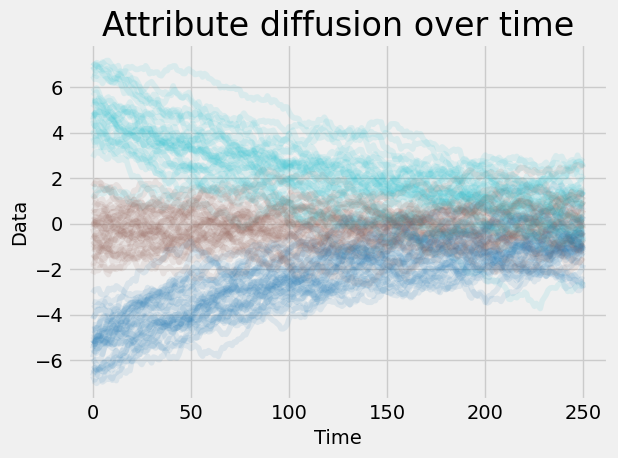

In [9]:
plot_diffusion_over_time(samples, 100, color_map=color_map, labels=y_train)

In [10]:
class MuModel(nn.Module):
    def __init__(self):
        super(MuModel, self).__init__()
        dim = 8
        self.model = nn.Sequential(
            nn.Linear(2, dim),
            nn.SiLU(),
            nn.Linear(dim, dim),
            nn.SiLU(),
            nn.Linear(dim, 1),
        )

    def forward(self, x):
        return self.model(x)


class SigmaModel(nn.Module):
    def __init__(self):
        super(SigmaModel, self).__init__()
        dim = 8
        self.model = nn.Sequential(
            nn.Linear(2, dim),
            nn.SiLU(),
            nn.Linear(dim, dim),
            nn.SiLU(),
            nn.Linear(dim, 1),
            nn.Softplus(),
        )

    def forward(self, x):
        return self.model(x)

In [11]:
mu_model = MuModel()
sigma_model = SigmaModel()

optimizer = optim.Adam(
    (*mu_model.parameters(), *sigma_model.parameters()),
    lr=learning_rate,
    weight_decay=weight_decay,
)

In [12]:
loss_history = []
log_step = 0

for epoch in range(epochs):
    for batch_data in train_loader:
        forward_distributions, forward_samples = forward_diffusion(
            batch_data, time_steps, beta
        )

        optimizer.zero_grad()
        loss = calculate_loss(
            forward_distributions, forward_samples, mu_model, sigma_model
        )
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

        if log_step % log_steps == 0:
            print(f"Epoch: {epoch}, Loss: {loss.item():.3f}")

        log_step += 1
    print(f"Epoch: {epoch}, Loss: {loss.item():.3f}")

Epoch: 0, Loss: 15.437
Epoch: 0, Loss: 6.993
Epoch: 1, Loss: 5.031
Epoch: 2, Loss: 3.077
Epoch: 3, Loss: 2.344
Epoch: 4, Loss: 1.952
Epoch: 5, Loss: 1.980
Epoch: 5, Loss: 1.992
Epoch: 6, Loss: 1.774
Epoch: 7, Loss: 1.781
Epoch: 8, Loss: 1.671
Epoch: 9, Loss: 1.770
Epoch: 10, Loss: 1.648
Epoch: 10, Loss: 1.614
Epoch: 11, Loss: 1.502
Epoch: 12, Loss: 1.562
Epoch: 13, Loss: 1.418
Epoch: 14, Loss: 1.409
Epoch: 15, Loss: 1.370
Epoch: 15, Loss: 1.331
Epoch: 16, Loss: 1.247
Epoch: 17, Loss: 1.161
Epoch: 18, Loss: 1.128
Epoch: 19, Loss: 0.974
Epoch: 20, Loss: 0.938
Epoch: 20, Loss: 0.898
Epoch: 21, Loss: 0.804
Epoch: 22, Loss: 0.497
Epoch: 23, Loss: 0.519
Epoch: 24, Loss: 0.398
Epoch: 25, Loss: 0.455
Epoch: 25, Loss: 0.404
Epoch: 26, Loss: 0.396
Epoch: 27, Loss: 0.326
Epoch: 28, Loss: 0.260
Epoch: 29, Loss: 0.256
Epoch: 30, Loss: 0.234
Epoch: 30, Loss: 0.202
Epoch: 31, Loss: 0.213
Epoch: 32, Loss: 0.191
Epoch: 33, Loss: 0.124
Epoch: 34, Loss: 0.123
Epoch: 35, Loss: 0.125
Epoch: 35, Loss: 0.117

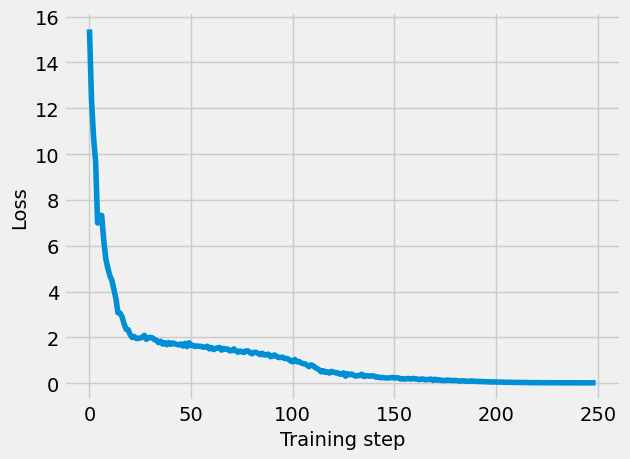

In [13]:
plt.plot(loss_history)
plt.ylabel("Loss")
plt.xlabel("Training step")
plt.show()

In [14]:
generated_samples = torch.stack(
    reverse_diffusion(mu_model, sigma_model, 1000, time_steps)
)

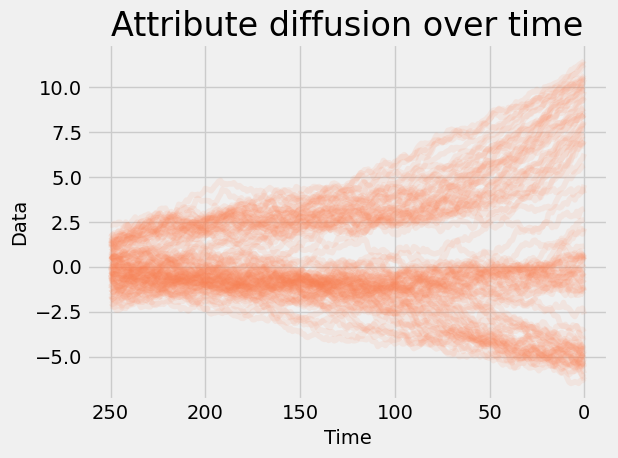

In [15]:
plot_diffusion_over_time(torch.flip(generated_samples, dims=(0,)), 100, invert=True)